<a href="https://colab.research.google.com/github/shaizalyasin/GNN-Path-Planning/blob/main/GNN_map_v0_pure_astar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [60]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque, defaultdict
import time
import heapq
import math


In [62]:
N = 20  # grid size: 8x8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def random_grid(p_block=0.2):
    """
    Returns an NxN grid:
      0 = free cell
      1 = blocked cell
    """
    grid = [[0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if random.random() < p_block:
                grid[i][j] = 1
    return grid

def random_start_goal(grid):
    """
    Pick two different free cells as (start, goal).
    Returns (start, goal) or (None, None) if not possible.
    """
    free_cells = [(i, j) for i in range(N) for j in range(N) if grid[i][j] == 0]
    if len(free_cells) < 2:
        return None, None
    start = random.choice(free_cells)
    remaining = [c for c in free_cells if c != start]
    goal = random.choice(remaining)
    return start, goal

def neighbors(i, j):
    """
    4-neighborhood (up, down, left, right).
    """
    for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < N and 0 <= nj < N:
            yield ni, nj

def bfs_shortest_path(grid, start, goal):
    """
    Breadth-first search for shortest path on an unweighted grid.
    Returns list of (i, j) cells from start to goal, or None if no path.
    """
    queue = deque()
    queue.append(start)
    came_from = {start: None}

    while queue:
        cur = queue.popleft()
        if cur == goal:
            # reconstruct path
            path = []
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path

        i, j = cur
        for ni, nj in neighbors(i, j):
            if grid[ni][nj] == 1:  # blocked
                continue
            nxt = (ni, nj)
            if nxt not in came_from:
                came_from[nxt] = cur
                queue.append(nxt)

    return None  # no path

def astar_shortest_path(grid, start, goal):
    """
    A* search for shortest path on an unweighted grid.
    Returns list of (i, j) cells from start to goal, or None if no path.
    Heuristic: Manhattan distance.
    """
    def h(cell):
        return abs(cell[0] - goal[0]) + abs(cell[1] - goal[1])

    open_heap = []
    heapq.heappush(open_heap, (h(start), 0, start))  # (f, g, node)

    came_from = {start: None}
    g_score = {start: 0}

    while open_heap:
        _, g, cur = heapq.heappop(open_heap)

        if cur == goal:
            # reconstruct
            path = []
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path

        i, j = cur
        for ni, nj in neighbors(i, j):
            if grid[ni][nj] == 1:
                continue

            nxt = (ni, nj)
            tentative_g = g + 1

            if nxt not in g_score or tentative_g < g_score[nxt]:
                g_score[nxt] = tentative_g
                came_from[nxt] = cur
                f = tentative_g + h(nxt)
                heapq.heappush(open_heap, (f, tentative_g, nxt))

    return None



baseline_test

In [63]:
# -------------------------------
# Reproducibility + Run Info
# -------------------------------
import platform, torch, numpy as np, random, time
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

RUN_INFO = {
    "seed": SEED,
    "grid_N": N,
    "p_block_train": 0.2,          # matches your generator in the PDF
    "teacher": "A*",               # dataset created using astar_shortest_path in generate_dataset
    "device": str(device),
    "torch": torch.__version__,
    "numpy": np.__version__,
    "timestamp_utc": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()),
}
print(RUN_INFO)


{'seed': 42, 'grid_N': 20, 'p_block_train': 0.2, 'teacher': 'A*', 'device': 'cuda', 'torch': '2.2.0+cu118', 'numpy': '1.26.4', 'timestamp_utc': '2026-01-29 13:55:46'}


In [64]:
def cell_to_index(i, j):
    """
    Maps (i, j) in the grid to a node index in [0, N*N-1].
    """
    return i * N + j


In [65]:
def grid_to_graph(grid, start, goal, path):
    num_nodes = N * N

    # Node features (8):
    # [is_blocked, is_start, is_goal, x_norm, y_norm,
    #  manhattan_to_goal_norm, manhattan_to_start_norm, euclid_to_goal_norm]
    x = torch.zeros((num_nodes, 8), dtype=torch.float)
    y = torch.zeros(num_nodes, dtype=torch.float)

    path_set = set(path) if path is not None else set()

    start_i, start_j = start
    goal_i, goal_j = goal

    # ---- node features + labels ----
    for i in range(N):
        for j in range(N):
            idx = cell_to_index(i, j)

            is_blocked = float(grid[i][j] == 1)
            is_start   = float((i, j) == start)
            is_goal    = float((i, j) == goal)

            x_norm = i / (N - 1)
            y_norm = j / (N - 1)

            man_goal = abs(i - goal_i) + abs(j - goal_j)
            man_start = abs(i - start_i) + abs(j - start_j)
            man_goal_norm = man_goal / (2 * (N - 1))
            man_start_norm = man_start / (2 * (N - 1))

            euclid = ((i - goal_i)**2 + (j - goal_j)**2) ** 0.5
            euclid_norm = euclid / ((2 * (N - 1)) ** 0.5)

            x[idx] = torch.tensor([
                is_blocked, is_start, is_goal,
                x_norm, y_norm,
                man_goal_norm, man_start_norm, euclid_norm
            ], dtype=torch.float)

            # soft labels: 1.0 on path, 0.3 if within 1 step of path, else 0.0
            if (i, j) in path_set:
                y[idx] = 1.0
            else:
                # check if any neighbor is on path
                near = False
                for ni, nj in neighbors(i, j):
                    if (ni, nj) in path_set:
                        near = True
                        break
                y[idx] = 0.3 if near else 0.0

    # ---- edges only between FREE cells ----
    edge_index_list = []
    for i in range(N):
        for j in range(N):
            if grid[i][j] == 1:
                continue
            idx = cell_to_index(i, j)
            for ni, nj in neighbors(i, j):
                if grid[ni][nj] == 1:
                    continue
                nidx = cell_to_index(ni, nj)
                edge_index_list.append([idx, nidx])

    if not edge_index_list:
        return None

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index, y=y)


In [66]:
def generate_dataset(num_samples=1200):
    data_list = []
    for _ in range(num_samples):
        grid = random_grid(p_block=0.2)
        start, goal = random_start_goal(grid)
        if start is None or goal is None:
            continue
        path = astar_shortest_path(grid, start, goal)
        if path is None:
            continue
        data = grid_to_graph(grid, start, goal, path)
        if data is not None:
            data_list.append(data)
    return data_list

dataset = generate_dataset(num_samples=1200)
print("Dataset size:", len(dataset))

print("Example x shape:", dataset[0].x.shape)  # should be [N*N, 8]
print("Example y shape:", dataset[0].y.shape)  # should be [N*N]



Dataset size: 1179
Example x shape: torch.Size([400, 8])
Example y shape: torch.Size([400])


In [67]:
random.shuffle(dataset)
n = len(dataset)
train_data = dataset[:int(0.7 * n)]
val_data   = dataset[int(0.7 * n):int(0.85 * n)]
test_data  = dataset[int(0.85 * n):]

# pos_weight = compute_pos_weight(train_data).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# print("pos_weight:", float(pos_weight.item()))

# Explicitly ensure all data is on CPU for DataLoaders
train_data = [d.to('cpu') for d in train_data]
val_data = [d.to('cpu') for d in val_data]
test_data = [d.to('cpu') for d in test_data]

len(train_data), len(val_data), len(test_data)

(825, 177, 177)

In [68]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=False)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=False)

In [69]:
from torch_geometric.nn import SAGEConv

class SAGEPathPredictor(nn.Module):
    def __init__(self, in_channels, hidden_dim=128, dropout=0.2, num_layers=5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.lin = nn.Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x).squeeze(-1)


In [70]:
print("Using device:", device)

model = SAGEPathPredictor(in_channels=8, hidden_dim=128, dropout=0.2, num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cuda


In [71]:
def compute_pos_weight(dataset):
    """
    Compute pos_weight over FREE cells only, using HARD labels:
      pos = y == 1.0
      neg = y == 0.0
    Ignore y==0.3 "near-path" soft labels so the ratio is stable.
    """
    pos, neg = 0, 0
    for d in dataset:
        free_mask = (d.x[:, 0] == 0)  # is_blocked == 0
        y = d.y[free_mask]
        pos += (y == 1.0).sum().item()
        neg += (y == 0.0).sum().item()
    return torch.tensor([neg / (pos + 1e-8)], dtype=torch.float)


In [72]:
# -------------------------------
# Loss function (GLOBAL)
# -------------------------------
pos_weight = compute_pos_weight(train_data).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("pos_weight:", float(pos_weight.item()))


pos_weight: 18.079633712768555


In [73]:
def _prf_from_preds(y_true, y_pred):
    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

def train_one_epoch(threshold=0.5):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index)

        free_mask = (batch.x[:, 0] == 0)  # is_blocked == 0
        loss = criterion(logits[free_mask], batch.y[free_mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [74]:
@torch.no_grad()
def evaluate(loader, threshold=0.5):
    model.eval()
    total_loss = 0.0

    all_y = []
    all_pred = []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)

        free_mask = (batch.x[:, 0] == 0)
        loss = criterion(logits[free_mask], batch.y[free_mask])
        total_loss += loss.item()

        probs = torch.sigmoid(logits[free_mask])
        preds = (probs > threshold).float()

        all_y.append(batch.y[free_mask].detach().cpu())
        all_pred.append(preds.detach().cpu())

    y_true_soft = torch.cat(all_y)
    y_pred = torch.cat(all_pred)

    # ✅ Convert soft labels to hard labels for metrics
    y_true = (y_true_soft >= 0.5).float()

    accuracy = (y_true == y_pred).float().mean().item()
    precision, recall, f1 = _prf_from_preds(y_true, y_pred)

    return (total_loss / len(loader)), accuracy, precision, recall, f1


In [75]:
num_epochs = 60

train_losses = []
val_losses = []
val_f1s = []

threshold = 0.5  # we will tune later

for epoch in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(threshold=threshold)
    va_loss, va_acc, va_prec, va_rec, va_f1 = evaluate(val_loader, threshold=threshold)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_f1s.append(va_f1)

    print(f"Epoch {epoch:02d} | TrainLoss {tr_loss:.4f} | ValLoss {va_loss:.4f} | "
          f"ValAcc {va_acc:.4f} | ValP {va_prec:.3f} | ValR {va_rec:.3f} | ValF1 {va_f1:.3f}")


Epoch 01 | TrainLoss 1.3169 | ValLoss 0.9465 | ValAcc 0.6341 | ValP 0.101 | ValR 0.916 | ValF1 0.182
Epoch 02 | TrainLoss 1.0490 | ValLoss 0.8877 | ValAcc 0.6595 | ValP 0.108 | ValR 0.914 | ValF1 0.193
Epoch 03 | TrainLoss 1.0002 | ValLoss 0.9023 | ValAcc 0.5918 | ValP 0.095 | ValR 0.958 | ValF1 0.173
Epoch 04 | TrainLoss 0.9711 | ValLoss 0.8761 | ValAcc 0.6132 | ValP 0.099 | ValR 0.945 | ValF1 0.179
Epoch 05 | TrainLoss 0.9417 | ValLoss 0.8369 | ValAcc 0.7206 | ValP 0.124 | ValR 0.873 | ValF1 0.218
Epoch 06 | TrainLoss 0.9523 | ValLoss 0.8444 | ValAcc 0.6457 | ValP 0.106 | ValR 0.939 | ValF1 0.191
Epoch 07 | TrainLoss 0.9299 | ValLoss 0.9178 | ValAcc 0.5519 | ValP 0.088 | ValR 0.973 | ValF1 0.162
Epoch 08 | TrainLoss 0.9279 | ValLoss 0.8439 | ValAcc 0.7228 | ValP 0.125 | ValR 0.869 | ValF1 0.218
Epoch 09 | TrainLoss 0.9245 | ValLoss 0.8683 | ValAcc 0.5955 | ValP 0.096 | ValR 0.958 | ValF1 0.174
Epoch 10 | TrainLoss 0.9076 | ValLoss 0.8847 | ValAcc 0.5843 | ValP 0.094 | ValR 0.963 | Va

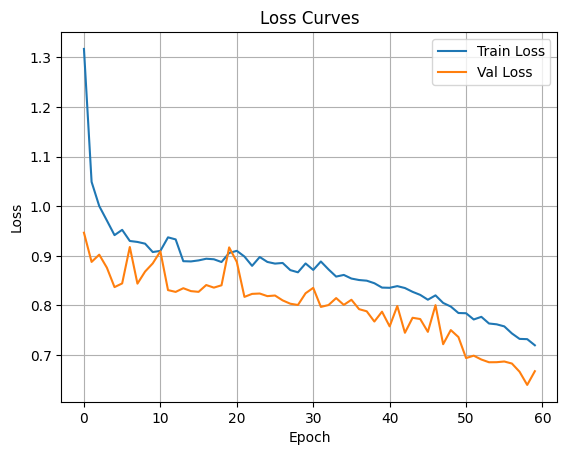

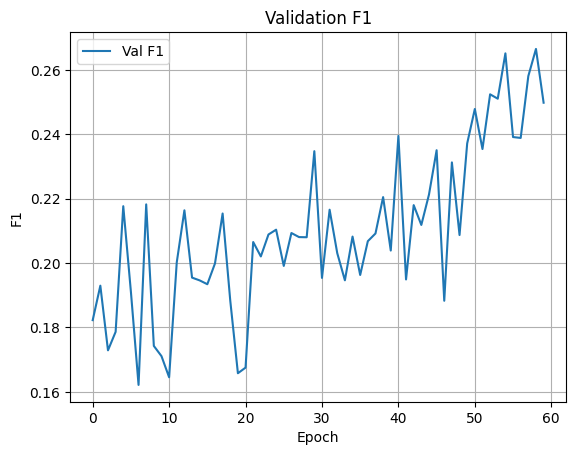

In [76]:

# plots
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.title("Validation F1")
plt.legend(); plt.grid(True); plt.show()

# plt.figure()
# plt.plot(val_accuracies, label="Val Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Validation Accuracy over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()



In [77]:
@torch.no_grad()
def best_threshold_on_val(loader, steps=101):
    """
    Finds threshold in [0,1] maximizing F1 on validation set.
    """
    best_t, best_f1 = 0.5, -1.0
    for k in range(steps):
        t = k / (steps - 1)
        _, _, _, _, f1 = evaluate(loader, threshold=t)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

t_star, f1_star = best_threshold_on_val(val_loader)
print("Best threshold:", t_star, "Best Val F1:", f1_star)


Best threshold: 0.9 Best Val F1: 0.4360354606852622


In [78]:
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader, threshold=t_star)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Test Prec: {test_prec:.4f}")
print(f"Test Rec:  {test_rec:.4f}")
print(f"Test F1:   {test_f1:.4f}")


Test Loss: 0.8615
Test Acc:  0.9295
Test Prec: 0.3562
Test Rec:  0.4552
Test F1:   0.3996


In [79]:
import numpy as np

In [80]:
@torch.no_grad()
def visualize_sample(idx=0, threshold=0.5):
    data = test_data[idx]  # CPU
    model.eval()

    data_gpu = data.to(device)
    logits = model(data_gpu.x, data_gpu.edge_index)
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    # SAFE: no NumPy dependency
    y_true = data.y.cpu().tolist()
    y_pred = preds.cpu().tolist()
    x_features = data.x.cpu().tolist()

    is_blocked = [f[0] for f in x_features]
    is_start   = [f[1] for f in x_features]
    is_goal    = [f[2] for f in x_features]

    true_grid  = np.zeros((N, N))
    pred_grid  = np.zeros((N, N))
    block_grid = np.zeros((N, N))
    start_grid = np.zeros((N, N))
    goal_grid  = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            idx_node = cell_to_index(i, j)
            true_grid[i, j]  = y_true[idx_node]
            pred_grid[i, j]  = y_pred[idx_node]
            block_grid[i, j] = is_blocked[idx_node]
            start_grid[i, j] = is_start[idx_node]
            goal_grid[i, j]  = is_goal[idx_node]

    img = np.zeros((N, N, 3), dtype=float)
    img[:, :, :] = 0.9
    img[block_grid == 1] = [0.0, 0.0, 0.0]
    img[true_grid == 1]  = [0.3, 1.0, 0.3]

    pred_mask = (pred_grid == 1)
    img[pred_mask] = img[pred_mask] * 0.5 + np.array([0.3, 0.3, 1.0]) * 0.5

    img[start_grid == 1] = [1.0, 0.2, 0.2]
    img[goal_grid == 1]  = [0.7, 0.0, 0.0]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Green=True | Blue=Pred (t={threshold:.2f}) | Red=Start/Goal | Black=Obstacle")
    plt.axis("off")
    plt.show()


In [81]:
import numpy
print(f"Current NumPy version: {numpy.__version__}")

Current NumPy version: 1.26.4


The previous errors `RuntimeError: Numpy is not available` and `Failed to initialize NumPy` are due to an incompatibility between NumPy 2.x and the installed PyTorch version. To fix this, we need to downgrade NumPy to a 1.x version. After executing the next cell, **please restart the runtime** for the changes to take effect.

In [82]:
!pip install numpy==1.26.4

After restarting the runtime, you can re-run the `visualize_sample` and `plot_prob_histogram` cells.

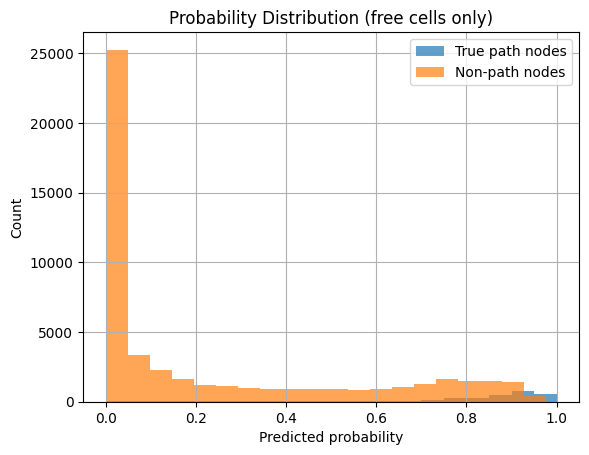


--- Planner Evaluation (test_data) ---
{'astar_success_rate': 1.0, 'greedy_success_rate': 1.0, 'neural_success_rate': 1.0, 'astar_avg_len': 15.44632768361582, 'greedy_avg_len': 17.994350282485875, 'neural_avg_len': 15.44632768361582, 'astar_avg_time_s': 0.000845936237274248, 'greedy_avg_time_s': 0.0014437884067563902, 'neural_avg_time_s': 0.0016888174745872675, 'greedy_len_ratio_vs_astar': 1.3485619177510024, 'neural_len_ratio_vs_astar': 1.0, 'astar_avg_expansions': 38.41242937853107, 'neural_avg_expansions': 33.909604519774014}


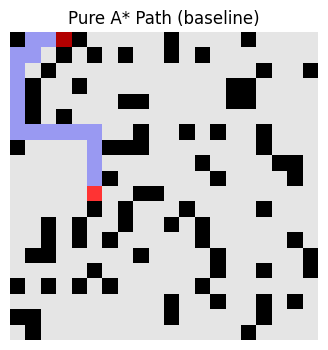

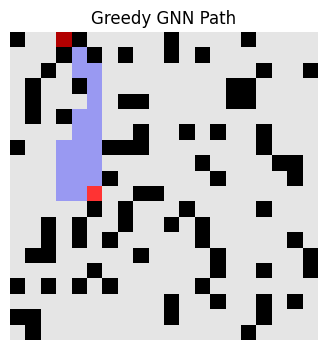

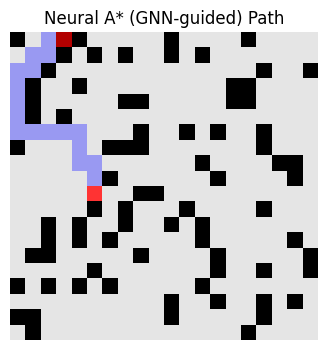

In [83]:
@torch.no_grad()
def plot_prob_histogram(loader):
    model.eval()
    all_probs = []
    all_labels = []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)
        free_mask = (batch.x[:, 0] == 0)

        probs = torch.sigmoid(logits[free_mask]).detach().cpu().numpy()
        labels = batch.y[free_mask].detach().cpu().numpy()

        all_probs.extend(list(probs))
        all_labels.extend(list(labels))

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    plt.figure()
    plt.hist(all_probs[all_labels == 1], bins=20, alpha=0.7, label="True path nodes")
    plt.hist(all_probs[all_labels == 0], bins=20, alpha=0.7, label="Non-path nodes")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.title("Probability Distribution (free cells only)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prob_histogram(test_loader)
# ============================================================
# Phase 3: Inference & Path Reconstruction (NEXT STEP)
# ============================================================

def get_start_goal_from_data(data):
    """
    Extract start and goal node indices from node features.
    x[:,1] = is_start, x[:,2] = is_goal
    """
    x = data.x
    start_idx = int((x[:, 1] == 1).nonzero(as_tuple=False)[0].item())
    goal_idx  = int((x[:, 2] == 1).nonzero(as_tuple=False)[0].item())
    return start_idx, goal_idx

def build_adj_list(edge_index, num_nodes):
    """
    edge_index: [2, E]
    returns adjacency list: list[list[int]] where adj[u] = neighbors of u
    """
    adj = [[] for _ in range(num_nodes)]
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    for s, d in zip(src, dst):
        adj[s].append(d)
    return adj

from collections import deque
import math, heapq
import numpy as np

def bfs_path_graph(data):
    """BFS on the Data graph (unweighted). Returns (path, expansions) or (None, expansions)."""
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    q = deque([start])
    came = {start: None}
    expansions = 0

    while q:
        u = q.popleft()
        expansions += 1
        if u == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came[cur]
            path.reverse()
            return path, expansions
        for v in adj[u]:
            if v not in came:
                came[v] = u
                q.append(v)

    return None, expansions


def dijkstra_path_graph(data):
    """Dijkstra on the Data graph (unit weights here). Returns (path, expansions)."""
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    dist = {start: 0.0}
    came = {start: None}
    pq = [(0.0, start)]
    expansions = 0

    while pq:
        d, u = heapq.heappop(pq)
        expansions += 1
        if u == goal:
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came[cur]
            path.reverse()
            return path, expansions
        if d > dist.get(u, math.inf):
            continue
        for v in adj[u]:
            nd = d + 1.0
            if nd < dist.get(v, math.inf):
                dist[v] = nd
                came[v] = u
                heapq.heappush(pq, (nd, v))

    return None, expansions


# def random_walk_path(data, max_steps=400):
#     """Random baseline: random walk without revisiting if possible."""
#     start, goal = get_start_goal_from_data(data)
#     adj = build_adj_list(data.edge_index, data.num_nodes)
#     cur = start
#     path = [cur]
#     visited = {cur}

#     for _ in range(max_steps):
#         if cur == goal:
#             return path
#         candidates = [n for n in adj[cur] if n not in visited]
#         if not candidates:
#             # allow revisit if stuck
#             candidates = adj[cur]
#             if not candidates:
#                 return None
#         nxt = random.choice(candidates)
#         path.append(nxt)
#         visited.add(nxt)
#         cur = nxt
#     return None


def path_len_nodes(path):
    return (len(path) - 1) if path is not None else None


@torch.no_grad()
def predict_node_probs(data):
    """
    Runs GNN and returns per-node probabilities (CPU tensor shape [num_nodes]).
    """
    model.eval()
    data_gpu = data.to(device)
    logits = model(data_gpu.x, data_gpu.edge_index)
    probs = torch.sigmoid(logits).detach().cpu()
    return probs

def greedy_path(data, probs, max_steps=400):
    """
    Greedy reconstruction:
      start -> repeatedly choose neighbor with max prob until goal or stuck.
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    current = start
    path = [current]
    visited = set([current])

    for _ in range(max_steps):
        if current == goal:
            return path

        candidates = [n for n in adj[current] if n not in visited]
        if not candidates:
            return path

        next_node = max(candidates, key=lambda n: float(probs[n]))
        visited.add(next_node)
        path.append(next_node)
        current = next_node

    return None

def manhattan_idx(a, b):
    """
    Manhattan distance on the NxN grid using node indices.
    """
    ax, ay = divmod(a, N)
    bx, by = divmod(b, N)
    return abs(ax - bx) + abs(ay - by)

def astar_path(data):
    """
    Pure A* on the same graph (no GNN).
    Uses Manhattan distance heuristic on the NxN grid indices.
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    open_heap = []
    heapq.heappush(open_heap, (0.0, start))

    came_from = {start: None}
    g_score = defaultdict(lambda: math.inf)
    g_score[start] = 0.0

    expansions = 0

    while open_heap:
        _, current = heapq.heappop(open_heap)
        expansions += 1

        if current == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path, expansions

        for nb in adj[current]:
            tentative_g = g_score[current] + 1.0  # unit edge costs
            if tentative_g < g_score[nb]:
                came_from[nb] = current
                g_score[nb] = tentative_g

                h = manhattan_idx(nb, goal)
                f = tentative_g + h

                heapq.heappush(open_heap, (f, nb))

    return None, expansions


def neural_astar_path(data, probs, alpha=2.0):
    """
    Hybrid A* guided by GNN:
      f(n) = g(n) + h(n) + alpha*(1 - prob(n))
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    open_heap = []
    heapq.heappush(open_heap, (0.0, start))

    came_from = {start: None}
    g_score = defaultdict(lambda: math.inf)
    g_score[start] = 0.0
    expansions = 0

    while open_heap:
        _, current = heapq.heappop(open_heap)
        expansions += 1

        if current == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path, expansions

        for nb in adj[current]:
            tentative_g = g_score[current] + 1.0
            if tentative_g < g_score[nb]:
                came_from[nb] = current
                g_score[nb] = tentative_g

                h = manhattan_idx(nb, goal)
                bias = alpha * (1.0 - float(probs[nb]))
                f = tentative_g + h + bias

                heapq.heappush(open_heap, (f, nb))

    return None, expansions

def path_length(path):
    return (len(path) - 1) if path is not None else None

@torch.no_grad()
def evaluate_planners(dataset, alpha=2.0):
    """
    Runs:
      - Pure A*
      - Greedy-GNN
      - Neural A* (GNN-guided)
    Reports:
      - success rates
      - average path length (for successes)
      - average runtime
      - length ratios vs A*
      - expansions (A* nodes popped)
    """
    astar_success = 0
    greedy_success = 0
    neural_success = 0

    astar_lengths, greedy_lengths, neural_lengths = [], [], []
    astar_times, greedy_times, neural_times = [], [], []
    astar_expansions, neural_expansions = [], []

    greedy_len_ratios, neural_len_ratios = [], []

    for data in dataset:
        # ---------- Pure A* ----------
        t0 = time.perf_counter()
        apath, aexp = astar_path(data)
        t1 = time.perf_counter()
        astar_times.append(t1 - t0)
        astar_expansions.append(aexp)

        a_len = path_length(apath)
        if apath is not None:
            astar_success += 1
            astar_lengths.append(a_len)

        # ---------- GNN probs once ----------
        probs = predict_node_probs(data)

        # ---------- Greedy ----------
        t0 = time.perf_counter()
        gpath = greedy_path(data, probs)
        t1 = time.perf_counter()
        greedy_times.append(t1 - t0)

        g_len = path_length(gpath)
        if gpath is not None:
            greedy_success += 1
            greedy_lengths.append(g_len)

        # ---------- Neural A* ----------
        t0 = time.perf_counter()
        npath, nexp = neural_astar_path(data, probs, alpha=alpha)
        t1 = time.perf_counter()
        neural_times.append(t1 - t0)
        neural_expansions.append(nexp)

        n_len = path_length(npath)
        if npath is not None:
            neural_success += 1
            neural_lengths.append(n_len)

        # ---------- Ratios vs A* ----------
        if apath is not None and a_len is not None and a_len > 0:
            if gpath is not None and g_len is not None:
                greedy_len_ratios.append(g_len / a_len)
            if npath is not None and n_len is not None:
                neural_len_ratios.append(n_len / a_len)

    results = {
        "astar_success_rate": astar_success / len(dataset),
        "greedy_success_rate": greedy_success / len(dataset),
        "neural_success_rate": neural_success / len(dataset),

        "astar_avg_len": float(np.mean(astar_lengths)) if astar_lengths else None,
        "greedy_avg_len": float(np.mean(greedy_lengths)) if greedy_lengths else None,
        "neural_avg_len": float(np.mean(neural_lengths)) if neural_lengths else None,

        "astar_avg_time_s": float(np.mean(astar_times)),
        "greedy_avg_time_s": float(np.mean(greedy_times)),
        "neural_avg_time_s": float(np.mean(neural_times)),

        "greedy_len_ratio_vs_astar": float(np.mean(greedy_len_ratios)) if greedy_len_ratios else None,
        "neural_len_ratio_vs_astar": float(np.mean(neural_len_ratios)) if neural_len_ratios else None,

        # ✅ expansions (better than wall-clock timing)
        "astar_avg_expansions": float(np.mean(astar_expansions)) if astar_expansions else None,
        "neural_avg_expansions": float(np.mean(neural_expansions)) if neural_expansions else None,
    }
    return results



def plot_path_on_grid(data, path, title="Path"):
    """
    Draws a single path on the grid:
      black = obstacle, blue = path, red = start/goal
    """
    # If path is returned as (path, expansions), unpack it
    if isinstance(path, tuple):
        path = path[0]

    x = data.x.cpu().numpy()
    is_blocked = x[:, 0]
    is_start = x[:, 1]
    is_goal = x[:, 2]

    img = np.ones((N, N, 3)) * 0.9
    for idx in range(N * N):
        i, j = divmod(idx, N)
        if is_blocked[idx] == 1:
            img[i, j] = [0, 0, 0]

    # path
    if path is not None:
        for idx in path:
            i, j = divmod(idx, N)
            img[i, j] = img[i, j] * 0.5 + np.array([0.3, 0.3, 1.0]) * 0.5

    # start/goal
    s = int((data.x[:, 1] == 1).nonzero(as_tuple=False)[0].item())
    g = int((data.x[:, 2] == 1).nonzero(as_tuple=False)[0].item())
    si, sj = divmod(s, N)
    gi, gj = divmod(g, N)
    img[si, sj] = [1.0, 0.2, 0.2]
    img[gi, gj] = [0.7, 0.0, 0.0]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


# -------------------------------
# Run the planners on test set
# -------------------------------
print("\n--- Planner Evaluation (test_data) ---")
planner_results = evaluate_planners(test_data, alpha=2.0)
print(planner_results)

# -------------------------------
# Visualize one example map
# -------------------------------
example = test_data[0]
probs = predict_node_probs(example)

apath = astar_path(example)
gpath = greedy_path(example, probs)
npath = neural_astar_path(example, probs, alpha=2.0)

plot_path_on_grid(example, apath, title="Pure A* Path (baseline)")
plot_path_on_grid(example, gpath, title="Greedy GNN Path")
plot_path_on_grid(example, npath, title="Neural A* (GNN-guided) Path")


In [84]:
@torch.no_grad()
def evaluate_baseline_pack(dataset, alpha=2.0):#, max_steps_random=400):
    """
    Baseline pack:
      - BFS (optimal for unweighted)
      - Dijkstra (same here, but included)
      - A* (Manhattan heuristic)
      - Random walk(removed)
      - Greedy-GNN (your greedy_path)
      - Neural A* (your neural_astar_path)
    """

    # Storage (per method)
    methods = ["BFS", "Dijkstra", "A*", "GreedyGNN", "NeuralA*"]
    stats = {m: {"success": 0, "lens": [], "times": [], "exp": []} for m in methods}
    ratios_vs_bfs = {m: [] for m in methods if m != "BFS"}

    for data in dataset:
        # -------- BFS (optimal reference) --------
        t0 = time.perf_counter()
        bfs_p, bfs_e = bfs_path_graph(data)
        t1 = time.perf_counter()
        stats["BFS"]["times"].append(t1 - t0)
        stats["BFS"]["exp"].append(bfs_e)
        if bfs_p is not None:
            stats["BFS"]["success"] += 1
            bfs_len = path_len_nodes(bfs_p)
            stats["BFS"]["lens"].append(bfs_len)
        else:
            bfs_len = None

        # -------- Dijkstra --------
        t0 = time.perf_counter()
        dij_p, dij_e = dijkstra_path_graph(data)
        t1 = time.perf_counter()
        stats["Dijkstra"]["times"].append(t1 - t0)
        stats["Dijkstra"]["exp"].append(dij_e)
        dij_len = path_len_nodes(dij_p)
        if dij_p is not None:
            stats["Dijkstra"]["success"] += 1
            stats["Dijkstra"]["lens"].append(dij_len)
        if bfs_len is not None and dij_len is not None and bfs_len > 0:
            ratios_vs_bfs["Dijkstra"].append(dij_len / bfs_len)

        # -------- A* (your existing astar_path returns (path, expansions)) --------
        t0 = time.perf_counter()
        a_p, a_e = astar_path(data)
        t1 = time.perf_counter()
        stats["A*"]["times"].append(t1 - t0)
        stats["A*"]["exp"].append(a_e)
        a_len = path_len_nodes(a_p)
        if a_p is not None:
            stats["A*"]["success"] += 1
            stats["A*"]["lens"].append(a_len)
        if bfs_len is not None and a_len is not None and bfs_len > 0:
            ratios_vs_bfs["A*"].append(a_len / bfs_len)

        # -------- Random walk --------
        # t0 = time.perf_counter()
        # r_p = random_walk_path(data, max_steps=max_steps_random)
        # t1 = time.perf_counter()
        # stats["Random"]["times"].append(t1 - t0)
        # r_len = path_len_nodes(r_p)
        # if r_p is not None:
        #     stats["Random"]["success"] += 1
        #     stats["Random"]["lens"].append(r_len)
        # if bfs_len is not None and r_len is not None and bfs_len > 0:
        #     ratios_vs_bfs["Random"].append(r_len / bfs_len)

        # -------- GNN probs once --------
        probs = predict_node_probs(data)

        # -------- Greedy-GNN --------
        t0 = time.perf_counter()
        g_p = greedy_path(data, probs)
        t1 = time.perf_counter()
        stats["GreedyGNN"]["times"].append(t1 - t0)
        g_len = path_len_nodes(g_p)
        if g_p is not None:
            stats["GreedyGNN"]["success"] += 1
            stats["GreedyGNN"]["lens"].append(g_len)
        if bfs_len is not None and g_len is not None and bfs_len > 0:
            ratios_vs_bfs["GreedyGNN"].append(g_len / bfs_len)

        # -------- Neural A* --------
        t0 = time.perf_counter()
        n_p, n_e = neural_astar_path(data, probs, alpha=alpha)
        t1 = time.perf_counter()
        stats["NeuralA*"]["times"].append(t1 - t0)
        stats["NeuralA*"]["exp"].append(n_e)
        n_len = path_len_nodes(n_p)
        if n_p is not None:
            stats["NeuralA*"]["success"] += 1
            stats["NeuralA*"]["lens"].append(n_len)
        if bfs_len is not None and n_len is not None and bfs_len > 0:
            ratios_vs_bfs["NeuralA*"].append(n_len / bfs_len)

    # Summarize
    out = {}
    n = len(dataset)
    for m in methods:
        times = np.array(stats[m]["times"])
        lens = np.array(stats[m]["lens"]) if stats[m]["lens"] else np.array([])
        exp  = np.array(stats[m]["exp"])  if stats[m]["exp"]  else np.array([])

        out[m] = {
            "success_rate": stats[m]["success"] / n,
            "avg_len": float(lens.mean()) if len(lens) else None,
            "median_len": float(np.median(lens)) if len(lens) else None,
            "avg_time_s": float(times.mean()) if len(times) else None,
            "p95_time_s": float(np.percentile(times, 95)) if len(times) else None,
            "avg_expansions": float(exp.mean()) if len(exp) else None,
            "p95_expansions": float(np.percentile(exp, 95)) if len(exp) else None,
        }

    for m, arr in ratios_vs_bfs.items():
        arr = np.array(arr)
        out[m]["len_ratio_vs_bfs_avg"] = float(arr.mean()) if len(arr) else None
        out[m]["len_ratio_vs_bfs_p95"] = float(np.percentile(arr, 95)) if len(arr) else None

    return out


In [85]:
import json, os
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("\n--- Baseline Pack Evaluation (test_data) ---")
baseline_results = evaluate_baseline_pack(test_data, alpha=2.0)

print(json.dumps(baseline_results, indent=2))

with open("results/baseline_pack.json", "w") as f:
    json.dump({"run_info": RUN_INFO, "results": baseline_results}, f, indent=2)

print("Saved: results/baseline_pack.json")



--- Baseline Pack Evaluation (test_data) ---
{
  "BFS": {
    "success_rate": 1.0,
    "avg_len": 15.44632768361582,
    "median_len": 16.0,
    "avg_time_s": 0.0010324653502577173,
    "p95_time_s": 0.0029262896002364837,
    "avg_expansions": 165.045197740113,
    "p95_expansions": 308.0
  },
  "Dijkstra": {
    "success_rate": 1.0,
    "avg_len": 15.44632768361582,
    "median_len": 16.0,
    "avg_time_s": 0.0010737132542228704,
    "p95_time_s": 0.0030951375999393347,
    "avg_expansions": 165.4689265536723,
    "p95_expansions": 308.2,
    "len_ratio_vs_bfs_avg": 1.0,
    "len_ratio_vs_bfs_p95": 1.0
  },
  "A*": {
    "success_rate": 1.0,
    "avg_len": 15.44632768361582,
    "median_len": 16.0,
    "avg_time_s": 0.0009544820395244205,
    "p95_time_s": 0.0031514664000496847,
    "avg_expansions": 38.41242937853107,
    "p95_expansions": 106.0,
    "len_ratio_vs_bfs_avg": 1.0,
    "len_ratio_vs_bfs_p95": 1.0
  },
  "GreedyGNN": {
    "success_rate": 1.0,
    "avg_len": 17.9943502

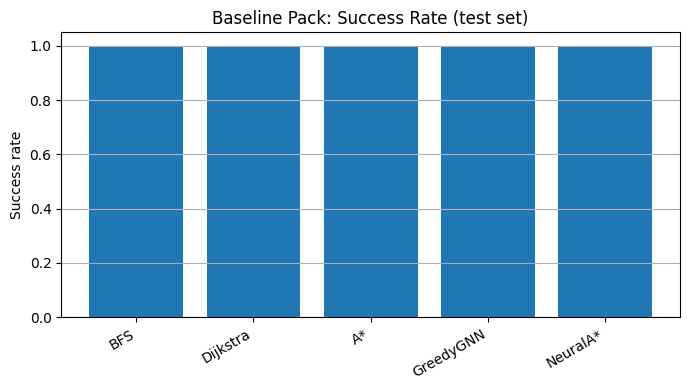

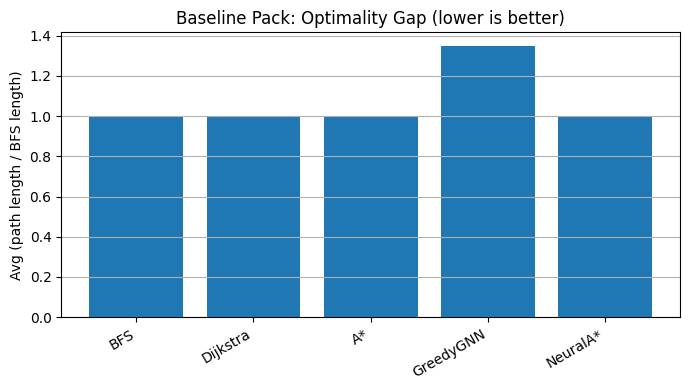

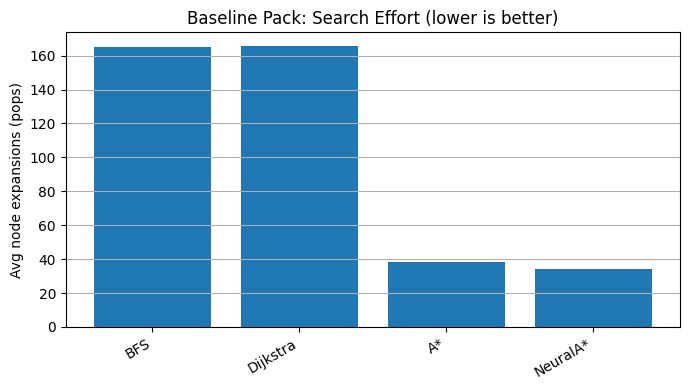

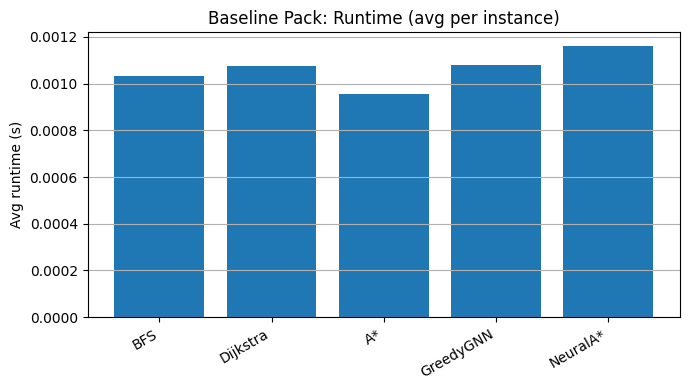

Saved charts to figures/: baseline_success.png, baseline_len_ratio.png, baseline_expansions.png, baseline_runtime.png


In [89]:
import matplotlib.pyplot as plt
import numpy as np

methods_order = ["BFS", "Dijkstra", "A*", "GreedyGNN", "NeuralA*"]

def get_arr(key):
    return [baseline_results[m].get(key, None) for m in methods_order]

# 1) Success rate bar
plt.figure(figsize=(7,4))
plt.bar(methods_order, get_arr("success_rate"))
plt.ylabel("Success rate")
plt.title("Baseline Pack: Success Rate (test set)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_success.png", dpi=200)
plt.show()

# 2) Path length ratio vs BFS (optimal) — where available
ratio = [baseline_results[m].get("len_ratio_vs_bfs_avg", None) for m in methods_order]
# BFS has no ratio; keep it as 1.0 for plotting
ratio = [1.0 if (m=="BFS") else ratio[i] for i,m in enumerate(methods_order)]

plt.figure(figsize=(7,4))
plt.bar(methods_order, ratio)
plt.ylabel("Avg (path length / BFS length)")
plt.title("Baseline Pack: Optimality Gap (lower is better)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_len_ratio.png", dpi=200)
plt.show()

# 3) Expansions (search effort) — only for BFS/Dijkstra/A*/NeuralA*
methods_order_2 = ["BFS", "Dijkstra", "A*", "NeuralA*"]

exp = [baseline_results[m].get("avg_expansions", None) for m in methods_order_2]
# Replace None with 0 for plotting
exp_plot = [0.0 if v is None else v for v in exp]

plt.figure(figsize=(7,4))
plt.bar(methods_order_2, exp_plot)
plt.ylabel("Avg node expansions (pops)")
plt.title("Baseline Pack: Search Effort (lower is better)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_expansions.png", dpi=200)
plt.show()

# 4) Runtime mean (seconds)
rt = [baseline_results[m].get("avg_time_s", None) for m in methods_order]
rt_plot = [0.0 if v is None else v for v in rt]

plt.figure(figsize=(7,4))
plt.bar(methods_order, rt_plot)
plt.ylabel("Avg runtime (s)")
plt.title("Baseline Pack: Runtime (avg per instance)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_runtime.png", dpi=200)
plt.show()

print("Saved charts to figures/: baseline_success.png, baseline_len_ratio.png, baseline_expansions.png, baseline_runtime.png")


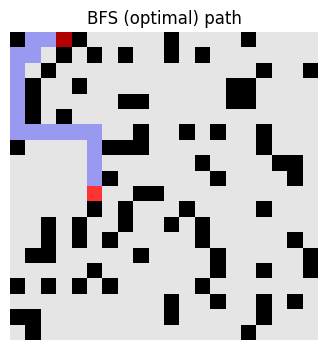

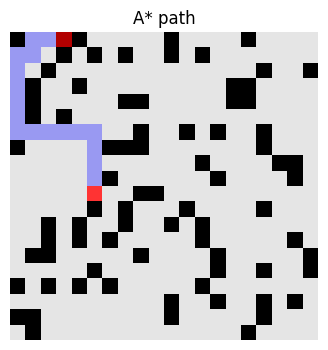

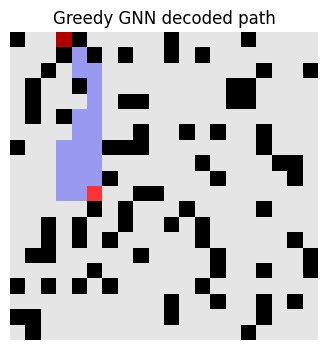

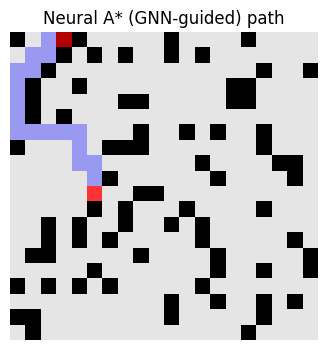

In [87]:
# Pick one example
example = test_data[0]
probs = predict_node_probs(example)

bfs_p, _ = bfs_path_graph(example)
a_p, _ = astar_path(example)
g_p = greedy_path(example, probs)
n_p, _ = neural_astar_path(example, probs, alpha=2.0)

plot_path_on_grid(example, bfs_p, title="BFS (optimal) path")
plot_path_on_grid(example, a_p, title="A* path")
plot_path_on_grid(example, g_p, title="Greedy GNN decoded path")
plot_path_on_grid(example, n_p, title="Neural A* (GNN-guided) path")


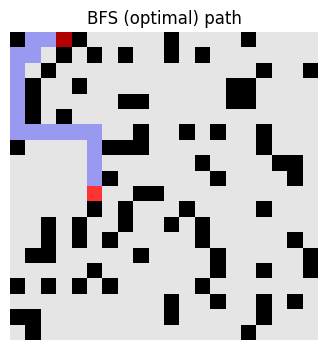

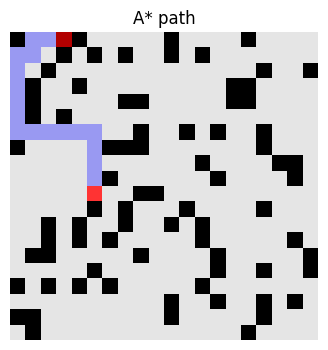

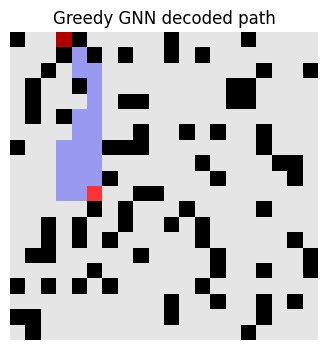

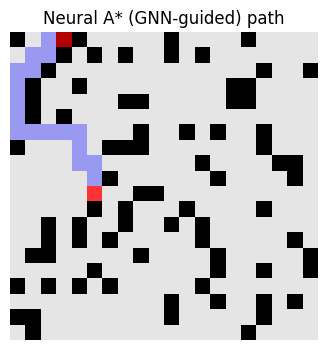

Saved qualitative path plots to figures/paths/:
 - figures/paths/paths_bfs_idx0.png
 - figures/paths/paths_astar_idx0.png
 - figures/paths/paths_greedy_idx0.png
 - figures/paths/paths_neural_idx0.png


In [90]:
# -------------------------------
# Save qualitative path plots (BFS / A* / GreedyGNN / NeuralA*)
# Put this near the end of the notebook (after training), after plot_path_on_grid is defined.
# -------------------------------
import os
import matplotlib.pyplot as plt

os.makedirs("figures/paths", exist_ok=True)

def save_path_plot(data, path, title, outpath):
    """Wrapper around your existing plot_path_on_grid that also saves the figure."""
    # draw
    plot_path_on_grid(data, path, title=title)
    # save the *current* figure created by matplotlib
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()

# Pick one test example (change index if you want)
idx = 0
example = test_data[idx]

# Compute paths
probs = predict_node_probs(example)

bfs_p, _ = bfs_path_graph(example)
a_p, _   = astar_path(example)
g_p      = greedy_path(example, probs)
n_p, _   = neural_astar_path(example, probs, alpha=2.0)

# Save images
save_path_plot(example, bfs_p, "BFS (optimal) path",         f"figures/paths/paths_bfs_idx{idx}.png")
save_path_plot(example, a_p,   "A* path",                    f"figures/paths/paths_astar_idx{idx}.png")
save_path_plot(example, g_p,   "Greedy GNN decoded path",    f"figures/paths/paths_greedy_idx{idx}.png")
save_path_plot(example, n_p,   "Neural A* (GNN-guided) path",f"figures/paths/paths_neural_idx{idx}.png")

print("Saved qualitative path plots to figures/paths/:")
print(f" - figures/paths/paths_bfs_idx{idx}.png")
print(f" - figures/paths/paths_astar_idx{idx}.png")
print(f" - figures/paths/paths_greedy_idx{idx}.png")
print(f" - figures/paths/paths_neural_idx{idx}.png")
